# Empirical Bayes with Python
## Purpose
I wanted to reproduce the functional code samples (originally written in R) from David Robinson's book [Introduction to Empirical Bayes: Examples from Baseball Statistics](http://varianceexplained.org/r/empirical-bayes-book/). Why would I want to reproduce it with Python?

1. I'm more comfortable with Python than R, so translating simple R functions gives me a good appreciation for what is fast in R and what is slow in R, and where to find R functionality that is familiar to me in Python.

2. I have been working on problems with Python that could benefit from empirical Bayesian methods. Working out some simple examples is good practice before thinking about more complicated problems.

3. Because R has benefitted from the work of at least a generation of statisticians, Python is relatively lacking some crucial functions. I wanted to see specific examples where Python is lacking (although there are many feature suggestions for free software to remedy some of these).

This notebook is a work-in-progress.

## What is in this notebook

1. Downloading Lahman baseball data and loading it into pandas. After a quick search, I did not find a package for Python like the `Lahman` package in R.

2. Maximum likelihood estimation for estimating the EB $\alpha_0, \beta_0$ using `scipy.optimize`.

In [19]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Chapter 1
## Plotting Beta distributions

In [20]:
from scipy.stats import beta, binom

x = np.linspace(0, 1, num=500)
for a, b in [(1, 2), (3, 3), (20, 20), (50, 10)]:
    plt.plot(beta.pdf(x, a, b), 
             label=r'$\alpha = {}, \beta = {}$'.format(a, b))

plt.legend()
plt.show()

In [21]:
num_trials = int(10e6)

true_average = beta.rvs(81, 219, size=num_trials)
hits = binom.rvs(300, true_average, size=num_trials)
simulations = pd.DataFrame({'true_average': true_average,
                           'hits': hits})
simulations.head()

hits  true_average
0    80      0.249802
1    70      0.258299
2    81      0.266275
3    77      0.250360
4    84      0.271559

In [22]:
simulations[simulations['hits'] == 100]['true_average'].hist(bins=31, 
                                                             normed=True)
x = np.linspace(0.22, 0.38, 200)
plt.plot(x, beta.pdf(x, 81+100, 219+200))
plt.ylabel('density')
plt.xlabel('Batting average of players who got 100 H / 300 AB');

In [23]:
# Fit the MLE $\alpha, \beta$
a, b, loc, scale = beta.fit(simulations[simulations['hits'] == 100]['true_average'])
print "alpha = ", a, "beta = ", b
print loc, scale

alpha =  97.5178275386 beta =  167.373687457
0.0682121590983 0.634078576305


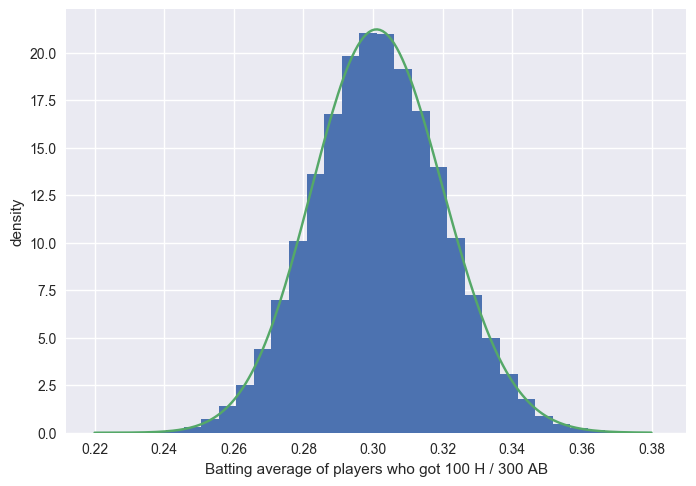

In [24]:
simulations[simulations['hits'] == 100]['true_average'].hist(bins=31, 
                                                             normed=True)
x = np.linspace(0.22, 0.38, 200)
plt.plot(x, beta.pdf(x, a, b, loc=loc, scale=scale))
plt.ylabel('density')
plt.xlabel('Batting average of players who got 100 H / 300 AB');

## Getting the Lahman data into pandas
In lieu of R's Lahman package, just use pandas to parse the CSV's.

First, start by downloading the current ZIP file from Lahman's website:

In [25]:
!wget http://seanlahman.com/files/database/baseballdatabank-2017.1.zip

--2017-05-27 13:17:31--  http://seanlahman.com/files/database/baseballdatabank-2017.1.zip
Resolving seanlahman.com... 69.163.163.148
Connecting to seanlahman.com|69.163.163.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8877742 (8.5M) [application/zip]
Saving to: ‘baseballdatabank-2017.1.zip.2’

baseballdatabank-20 100%[===================>]   8.47M  2.98MB/s    in 2.8s    

2017-05-27 13:17:34 (2.98 MB/s) - ‘baseballdatabank-2017.1.zip.2’ saved [8877742/8877742]



In [29]:
!unzip -f baseballdatabank-2017.1.zip

Archive:  baseballdatabank-2017.1.zip
048aa7aabb0090225e3aee4df8121785c9531c84


In [30]:
!ls

EmpiricalBayesPython.ipynb   baseballdatabank-2017.1.zip.1
baseballdatabank-2017.1      baseballdatabank-2017.1.zip.2
baseballdatabank-2017.1.zip


In [31]:
!ls baseballdatabank-2017.1/core

AllstarFull.csv		 FieldingOF.csv       PitchingPost.csv
Appearances.csv		 FieldingOFsplit.csv  Salaries.csv
AwardsManagers.csv	 FieldingPost.csv     Schools.csv
AwardsPlayers.csv	 HallOfFame.csv       SeriesPost.csv
AwardsShareManagers.csv  HomeGames.csv	      Teams.csv
AwardsSharePlayers.csv	 Managers.csv	      TeamsFranchises.csv
Batting.csv		 ManagersHalf.csv     TeamsHalf.csv
BattingPost.csv		 Master.csv	      readme2014.txt
CollegePlaying.csv	 Parks.csv
Fielding.csv		 Pitching.csv


In [32]:
Batting = pd.read_csv('baseballdatabank-2017.1/core/Batting.csv')
# Include post-season
#Batting = pd.concat([Batting, 
#                     pd.read_csv('baseballdatabank-2017.1/core/BattingPost.csv')],
#                   ignore_index=True)
Pitching = pd.read_csv('baseballdatabank-2017.1/core/Pitching.csv')

In [33]:
# Anti-join code adapted from
# https://stackoverflow.com/questions/38516664/anti-join-pandas
def anti_join(a, b, on=None):
    '''Keep all values from DataFrame a for which there are no
       matching values in DataFrame b.'''
    if not on: # if no key column specified, use index
        keys_keep = set(a.index) - set(b.index)
        where_keep = a.index.isin(keys_keep)
    else: # use an index
        keys_keep = set(a[on]) - set(b[on])
        where_keep = a[on].isin(keys_keep)
    return a[where_keep]

In [34]:
# Filter out pitchers
career = anti_join(Batting,#Batting[Batting.AB.notnull() & Batting.AB > 0],
                   Pitching, on='playerID') \
                .groupby('playerID') \
                .sum()[['H','AB']]
career['average'] = career['H']/career['AB']

In [35]:
# Include names along with player IDs
Master = pd.read_csv('baseballdatabank-2017.1/core/Master.csv')
career = career.join(Master[['playerID','nameFirst','nameLast']].set_index('playerID'))

career['name'] = career['nameFirst'].str.cat(career['nameLast'].astype(str), sep=' ')

career.drop(['nameFirst','nameLast'], axis=1, inplace=True)
career = career[['name','H','AB','average']].reset_index(drop=True)

In [36]:
career.head()

name     H     AB   average
0      Hank Aaron  3771  12364  0.304998
1    Tommie Aaron   216    944  0.228814
2       Andy Abad     2     21  0.095238
3     John Abadie    11     49  0.224490
4  Ed Abbaticchio   772   3044  0.253614

In [37]:
career['average'][career['AB']>500].hist(bins=50)
plt.xlim(0.15,0.36)
plt.ylabel('count')
plt.xlabel('average');

There is no beta-binomial distribution in SciPy that supports
fitting. See https://stackoverflow.com/questions/28375798/fit-beta-binomial.
So we'll have to write our own quick log-likelihood function.

The beta-binomial pmf is given by: 
$$f(k|n,\alpha,\beta) = \frac{\Gamma(n+1)}{\Gamma(k+1)\Gamma(n-k+1)} \frac{\Gamma(k+\alpha)\Gamma(n-k+\beta)}{\Gamma(n+\alpha+\beta)}\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}$$
or
$$f(k|n,\alpha,\beta) = {{n}\choose{k}}\frac{B(k+\alpha,n-k+\beta)}{B(\alpha,\beta)}$$

for $k$ successes in $n$ trials.

Here, $B(\alpha,\beta)$ is the Euler beta function.

The likelihood for $N$ samples would then be a product:
$$\prod_{i=1}^{N} f(k_i | n_i, \alpha, \beta)$$
so the log-likelihood would be:
$$\sum_{i=1}^{N}\log\left(f(k_i | n_i, \alpha, \beta)\right) = \sum_{i=1}^{N}\log{{n_i}\choose{k_i}} + \log(B(k_i+\alpha,n_i-k_i+\beta)) - \log(B(\alpha,\beta))$$.

To maximize the log-likelihood, we can minimize the *negative* log-likelihood.

In [81]:
alpha=1
beta=10
positive = np.sum([gammaln(x) for x in [n+1, k+alpha, n-k+beta, alpha + beta]])
negative = np.sum([gammaln(x) for x in [k+1, n-k+1, n+alpha+beta, alpha, beta]])
-np.sum(positive - negative)

33234.277415187826

In [82]:
from scipy.special import comb, betaln, gammaln
def betabinom_negLL(alphabeta, k=[], n=[]):
    '''Compute the negative log-likelihood of the beta-binomial distribution for 
       a set of experiments with k_i successes in n_i trials.'''
    alpha, beta = alphabeta
    # Problem with np.log(comb(n,k)): when comb(n,k) is not exact, turns into infinity
    #result = np.log(comb(n, k)) + betaln(k + alpha, n - k + beta) - betaln(alpha, beta)
    positive = np.sum([gammaln(x) for x in [n+1, k+alpha, n-k+beta, alpha + beta]])
    negative = np.sum([gammaln(x) for x in [k+1, n-k+1, n+alpha+beta, alpha, beta]])
    #result = np.sum(np.sum(gammaln(x)) for x in )
    #result -= np.sum(np.sum(gammaln(x)) for x in [k+1, n-k+1, n+alpha+beta, alpha, beta])
    return -np.sum(positive - negative)

In [85]:
from scipy.optimize import minimize
from functools import partial

k = career['H'][career['AB']>500]
n = career['AB'][career['AB']>500]

to_opt = partial(betabinom_negLL, k=k, n=n)
alpha0, beta0 = minimize(to_opt, [1, 10], method='L-BFGS-B',
                         bounds=((1,10000),(1,10000)))['x']
print "alpha0 = {}, beta0 = {}".format(alpha0, beta0)

alpha0 = 106.277516244, beta0 = 301.575245452


In [86]:
# 3.3
# Empirical bayes estimates
career['eb_estimate'] = (career['H'] + alpha0) / (career['AB'] + alpha0 + beta0)

In [87]:
# Best batters
career.sort_values('eb_estimate', ascending=False).head()

name     H    AB   average  eb_estimate
4005        Rogers Hornsby  2930  8173  0.358497     0.353843
4188  Shoeless Joe Jackson  1772  4981  0.355752     0.348549
2143          Ed Delahanty  2596  7505  0.345903     0.341505
3529        Billy Hamilton  2158  6268  0.344288     0.339174
4487         Willie Keeler  2932  8591  0.341287     0.337629

In [238]:
# Worst batters
career.sort_values('eb_estimate', ascending=True).head()
# Note the consistency between these ranks and the ones in the book
# despite the slight difference in MLE estimates for alpha0 and beta0.

name    H    AB   average  eb_estimate
612       Bill Bergen  516  3028  0.170410     0.181113
6582        Ray Oyler  221  1265  0.174704     0.195640
2463  Henry Easterday  203  1129  0.179805     0.201241
9009    John Vukovich   90   559  0.161002     0.203007
337      George Baker   74   474  0.156118     0.204430

In [273]:
plt.scatter(career['average'], career['eb_estimate'], 
            c=np.log10(1+career['AB']), cmap=plt.get_cmap('viridis'),
            s=16)
plt.plot(np.linspace(0.15, 0.38, 2), np.linspace(0.15, 0.38, 2), color='r')
plt.plot([0,1],[alpha0/(alpha0+beta0),alpha0/(alpha0+beta0)], 'r--')
plt.colorbar(label='$\log_{10}(AB)$')

In [274]:
# Chapter 4
# Career dataframe as before.
career['alpha1'] = alpha0 + career['H']
career['beta1'] = beta0 + career['AB'] - career['H']

In [289]:
a,b = career.set_index('name')[['alpha1','beta1']].loc['Bernie Williams'].iloc[0]
a, b

(139.27751624430636, 440.5752454516811)

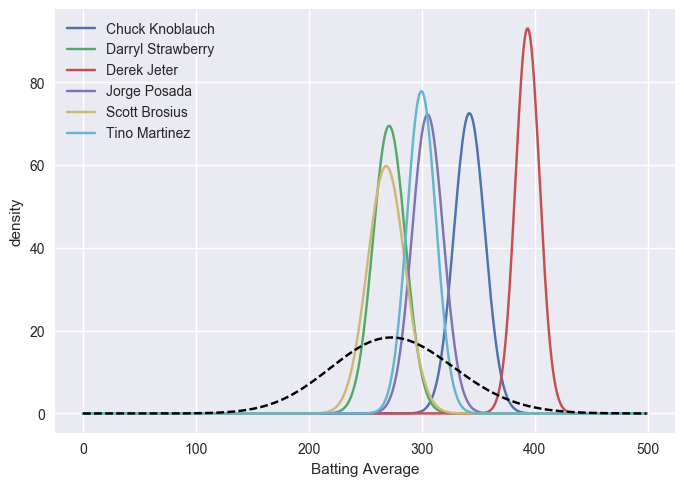

In [303]:
from scipy.stats import beta as betadist
player_names = ['Chuck Knoblauch','Darryl Strawberry',
               'Derek Jeter','Jorge Posada','Scott Brosius','Tino Martinez']

for p in player_names:
    a = career.set_index('name')['alpha1'].loc[p]
    b = career.set_index('name')['beta1'].loc[p]
    plt.plot(betadist.pdf(np.linspace(0.15, 0.35, 500), a, b), label=p)
    plt.legend()
    plt.ylabel('density')
    plt.xlabel('Batting Average')
plt.plot(betadist.pdf(np.linspace(0.15, 0.35, 500), alpha0, beta0), 'k--')
plt.show()

In [306]:
yankee_1998_career = career.set_index('name').loc[player_names].reset_index()
yankee_1998_career

name     H     AB   average  eb_estimate       alpha1  \
0    Chuck Knoblauch  1839   6366  0.288878     0.287174  1945.277516   
1  Darryl Strawberry  1401   5418  0.258583     0.258722  1507.277516   
2        Derek Jeter  3465  11195  0.309513     0.307793  3571.277516   
3       Jorge Posada  1664   6092  0.273145     0.272357  1770.277516   
4      Scott Brosius  1001   3889  0.257393     0.257695  1107.277516   
5      Tino Martinez  1925   7111  0.270707     0.270158  2031.277516   

         beta1  
0  4828.575245  
1  4318.575245  
2  8031.575245  
3  4729.575245  
4  3189.575245  
5  5487.575245

In [ ]:
# Confidence intervals, 4.3....later!

In [ ]:
# Chapter 5: Credible intervals
